In [41]:
import numpy as np
import awkward as ak
import pandas as pd
import pyarrow as pa
import xgboost as xgb
import pickle
from xgboost import XGBClassifier
#from root_numpy import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import uproot
import seaborn

In [42]:
### Get the root file with the tree name and make array of all data
events_sig = uproot.open("skimmed_BDT/GJet_PT-15to6000_TuneCP5-Flat_13p6TeV_0to19_sig.root:treeS")
print(events_sig)
sig_events = events_sig.arrays(["photon_sieip",
                            "photon_sieie",
                            "photon_r9",
                            "photon_etaWidth",
                            "photon_phiWidth",
                            "photon_esEnergyOverRawE",
                            "photon_esEffSigmaRR",
                            #"photon_pfPhoIso03",
                            "photon_hoe",
                            #"photon_ecalPFClusterIso",
                            #"photon_hcalPFClusterIso",
                            "photon_energyRaw",   
                            #"photon_pfChargedIsoPFPV",
                            #"photon_pfChargedIsoWorstVtx",
                            "photon_s4",
                            #"photon_sipip",
                            "isPhoton"])
sig_df = ak.to_pandas(sig_events)
#print(tot_df)

<TTree 'treeS' (18 branches) at 0x7ff0a8070a00>


In [43]:
### Get the root file with the tree name and make array of all data
events_bkg = uproot.open("skimmed_BDT/GJet_PT-15to6000_TuneCP5-Flat_13p6TeV_0to29_bkg.root:treeB")
print(events_bkg)
bkg_events = events_bkg.arrays(["photon_sieip",
                            "photon_sieie",
                            "photon_r9",
                            "photon_etaWidth",
                            "photon_phiWidth",
                            "photon_esEnergyOverRawE",
                            "photon_esEffSigmaRR",
                            #"photon_pfPhoIso03",
                            "photon_hoe",
                            #"photon_ecalPFClusterIso",
                            #"photon_hcalPFClusterIso",
                            "photon_energyRaw",   
                            #"photon_pfChargedIsoPFPV",
                            #"photon_pfChargedIsoWorstVtx",
                            "photon_s4",
                            #"photon_sipip",
                            "isPhoton"])
bkg_df = ak.to_pandas(bkg_events)

<TTree 'treeB' (18 branches) at 0x7ff0a63ae350>


In [44]:
sig_data = sig_df.to_numpy()
bkg_data = bkg_df.to_numpy()
print(bkg_data)

[[ 1.85370445e-05  1.55639648e-02  8.45703125e-01 ...  2.08250000e+02
   7.53906250e-01  0.00000000e+00]
 [-2.20537186e-05  8.48388672e-03  9.14062500e-01 ...  2.07875000e+02
   7.77343750e-01  0.00000000e+00]
 [ 9.29832458e-05  5.87463379e-03  6.19140625e-01 ...  4.92187500e+01
   8.37890625e-01  0.00000000e+00]
 ...
 [-1.32560730e-04  1.14746094e-02  8.94531250e-01 ...  1.81875000e+01
   6.93359375e-01  0.00000000e+00]
 [ 5.47170639e-05  8.75854492e-03  6.95312500e-01 ...  1.49375000e+01
   7.75390625e-01  0.00000000e+00]
 [-6.79016113e-04  4.06494141e-02  8.78906250e-01 ...  5.01875000e+01
   6.48437500e-01  0.00000000e+00]]


In [45]:
XSig = sig_data[:,0:10]   ### pick elements from 0 to 5 
YSig = sig_data[:,10]
XBkg = bkg_data[:,0:10]
YBkg = bkg_data[:,10]
print(XSig)
print(YSig)
print(YBkg)

[[-9.73232090e-08  9.82666016e-03  9.62890625e-01 ...  1.83868408e-03
   3.82250000e+02  9.00390625e-01]
 [ 1.44004822e-04  2.39868164e-02  9.78515625e-01 ...  4.76074219e-03
   8.07500000e+02  8.96484375e-01]
 [-1.01625919e-05  9.67407227e-03  9.57031250e-01 ...  6.62231445e-03
   2.29625000e+02  9.10156250e-01]
 ...
 [ 8.77305865e-07  8.69750977e-03  9.37500000e-01 ...  1.52206421e-03
   1.36200000e+03  8.41796875e-01]
 [-5.37931919e-06  9.61303711e-03  9.53125000e-01 ...  6.34765625e-03
   6.77500000e+02  8.96484375e-01]
 [-1.20997429e-05  9.24682617e-03  9.53125000e-01 ...  7.65991211e-03
   4.25250000e+02  9.12109375e-01]]
[1. 1. 1. ... 1. 1. 1.]
[0. 0. 0. ... 0. 0. 0.]


In [46]:
seed = 7
test_size = 0.33
X_trainSig, X_testSig, Y_trainSig, Y_testSig = train_test_split(XSig, YSig, test_size=test_size, random_state=seed)
X_trainBkg, X_testBkg, Y_trainBkg, Y_testBkg = train_test_split(XBkg, YBkg, test_size=test_size, random_state=seed)
print("X_trainSig shape: ",X_trainSig.shape)
print("X_testig shape: ",X_testSig.shape)
print("Y_trainSig shape: ",Y_trainSig.shape)
print("Y_testig shape: ",Y_testSig.shape)

X_trainSig shape:  (2075534, 10)
X_testig shape:  (1022279, 10)
Y_trainSig shape:  (2075534,)
Y_testig shape:  (1022279,)


In [47]:
X_train = np.vstack((X_trainSig, X_trainBkg))
X_test = np.vstack((X_testSig,X_testBkg))
Y_train = np.hstack((Y_trainSig,Y_trainBkg))
Y_test = np.hstack((Y_testSig,Y_testBkg))
print(X_train)
print(Y_train)

[[-1.37835741e-06  9.39941406e-03  9.68750000e-01 ...  3.41033936e-03
   2.14000000e+02  8.96484375e-01]
 [ 5.99622726e-05  2.27050781e-02  9.90234375e-01 ...  9.82666016e-03
   1.42500000e+03  9.29687500e-01]
 [-1.75833702e-05  9.46044922e-03  9.70703125e-01 ...  0.00000000e+00
   1.18250000e+02  9.12109375e-01]
 ...
 [ 1.86443329e-04  4.18701172e-02  6.56250000e-01 ...  3.82812500e-01
   5.55000000e+02  6.91406250e-01]
 [ 4.44412231e-04  2.49023438e-02  7.77343750e-01 ...  6.39648438e-02
   7.53750000e+01  6.05468750e-01]
 [ 8.60691071e-05  5.40771484e-02  5.62500000e-01 ...  4.84375000e-01
   1.13625000e+02  4.78515625e-01]]
[1. 1. 1. ... 0. 0. 0.]


In [97]:
# fit model no training data
model = XGBClassifier(learning_rate=0.1,max_depth=15)
gbm = model.fit(X_train, Y_train)
print(model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


In [98]:
# make predictions for test data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
predictions = [round(value) for value in y_pred]

In [99]:
# evaluate predictions
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.67%


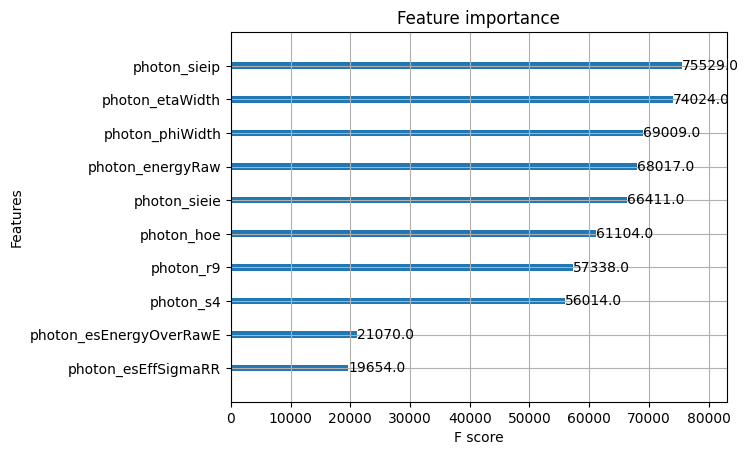

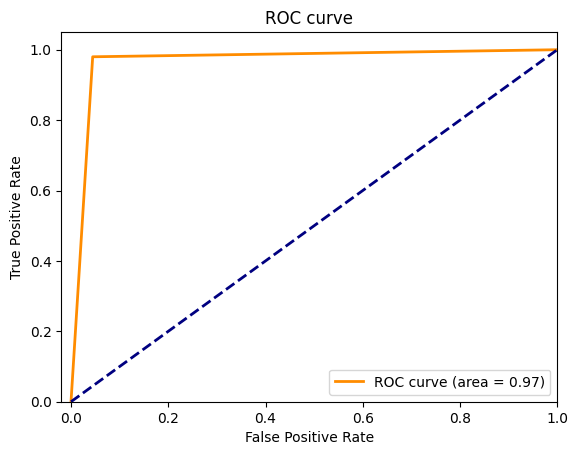

In [100]:
# Compute micro-average ROC curve and ROC area
name_Var = ["photon_sieip",
                            "photon_sieie",
                            "photon_r9",
                            "photon_etaWidth",
                            "photon_phiWidth",
                            "photon_esEnergyOverRawE",
                            "photon_esEffSigmaRR",
                            #"photon_pfPhoIso03",
                            "photon_hoe",
                            #"photon_ecalPFClusterIso",
                            #"photon_hcalPFClusterIso",
                            "photon_energyRaw",   
                            #"photon_pfChargedIsoPFPV",
                            #"photon_pfChargedIsoWorstVtx",
                            "photon_s4",
                            #"photon_sipip"
                            ]
fpr, tpr, _ = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
gbm.get_booster().feature_names = name_Var
xgb.plot_importance(gbm)
#plt.show()
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

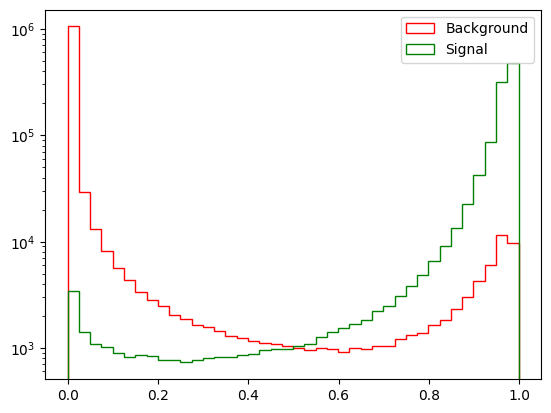

In [106]:
# Plot the output BDT distribution of Signal and Background
y_pred_proba_real = y_pred_proba[:,1]
y_pred_sig = []
y_pred_bkg = []
for i in range (len(Y_test)):
    if Y_test[i]==1:
        y_pred_sig.append(y_pred_proba_real[i])
    else:
        y_pred_bkg.append(y_pred_proba_real[i])
plt.hist([y_pred_sig, y_pred_bkg],color=['g','r'],histtype='step',bins=40, label=["Signal", "Background"])
#plt.hist([y_pred_sig, y_pred_bkg],color=['g','r'],histtype='step',bins=40, label=["Signal", "Background"], density=[True, True])
plt.yscale("log")
plt.legend()
plt.show()

In [102]:
corr_matrix_sig = sig_df.corr().drop("isPhoton").drop(columns="isPhoton")
corr_matrix_bkg = bkg_df.corr().drop("isPhoton").drop(columns="isPhoton")

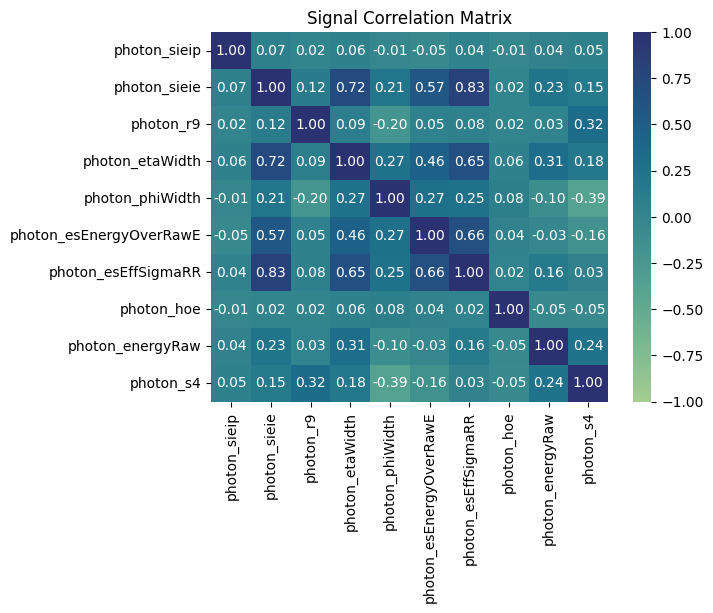

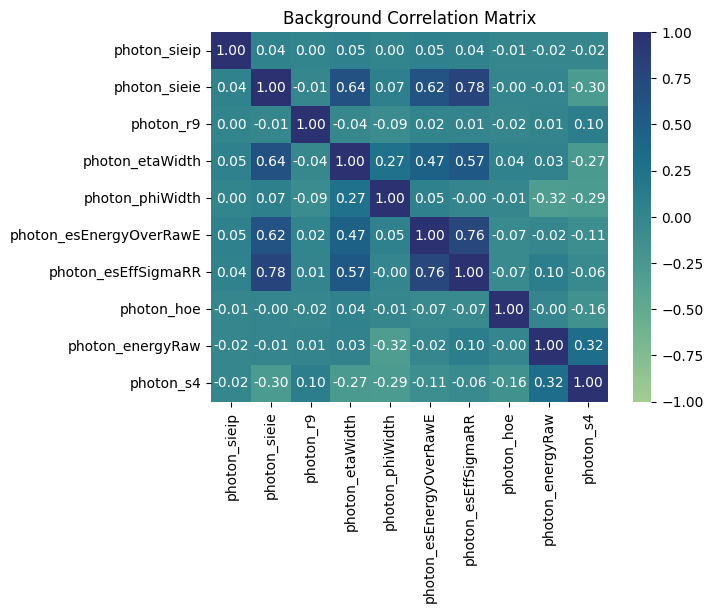

In [103]:
#Draw the correlation matrix for signal and background
import seaborn as sn
ax = plt.axes()
sn.heatmap(corr_matrix_sig, annot=True, cmap="crest", vmin=-1, vmax=1, fmt=".2f", ax=ax)
#plt.xticks(rotation=75) 
ax.set_title('Signal Correlation Matrix')
plt.show()

ax = plt.axes()
sn.heatmap(corr_matrix_bkg, annot=True, cmap="crest", vmin=-1, vmax=1, fmt=".2f", ax=ax)
#plt.xticks(rotation=75) 
ax.set_title('Background Correlation Matrix')
plt.show()

In [104]:
"""# Plot the different BDT input variables
plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = [7.50, 7.50]
plt.rcParams["figure.autolayout"] = True
#Nbins=[100,200,90,50,100,20]
#Range=[[0,200],[10,70],[0,90],[50,200],[0,500],[0,20]]
#Ncols = 2
#Nrows = 3
#xAxisLabel = ["$p_{T}^{l}$", "$m_{\gamma\gamma}$", "$m_{bb}$", "$m_{bb\gamma\gamma}$", "Met", "$n_{jet}$"]
Nbins=[100,90,50,100,20]
Range=[[0,200],[0,90],[50,200],[0,500],[0,20]]
Ncols = 5
Nrows = 2
xAxisLabel = ["$p_{T}^{l}$", "$m_{bb}$", "$m_{bb\gamma\gamma}$", "$p_{T}^{miss}$", "$n_{jet}$"]
figure, axis = plt.subplots(Nrows, Ncols)
counter=0
for i in range(Nrows):
    for j in range(Ncols):
        if (i+j+counter< len(Nbins)):
            axis[i,j].hist([X_testSig[:,i+j+counter], X_testBkg[:,i+j+counter]], color=['g','r'], histtype='stepfilled', bins=Nbins[i+j+counter], label=["Signal", "Background"], density=[True,True], range=Range[i+j+counter], alpha = 0.5)
            axis[i,j].set_xlabel(xAxisLabel[i+j+counter], fontsize=20)
            axis[i,j].set_ylabel("AU")
            axis[i,j].legend()
    counter = counter+Ncols-1
#plt.hist([X_testSig[:,2], X_testBkg[:,2],],color=['g','r'],histtype='step',bins=60, label=["Signal", "Background"], density=[True,True], range=[0,60])
plt.subplots_adjust(left=0.1, bottom=0.12, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()"""

'# Plot the different BDT input variables\nplt.rcParams[\'text.usetex\'] = True\nplt.rcParams["figure.figsize"] = [7.50, 7.50]\nplt.rcParams["figure.autolayout"] = True\n#Nbins=[100,200,90,50,100,20]\n#Range=[[0,200],[10,70],[0,90],[50,200],[0,500],[0,20]]\n#Ncols = 2\n#Nrows = 3\n#xAxisLabel = ["$p_{T}^{l}$", "$m_{\\gamma\\gamma}$", "$m_{bb}$", "$m_{bb\\gamma\\gamma}$", "Met", "$n_{jet}$"]\nNbins=[100,90,50,100,20]\nRange=[[0,200],[0,90],[50,200],[0,500],[0,20]]\nNcols = 5\nNrows = 2\nxAxisLabel = ["$p_{T}^{l}$", "$m_{bb}$", "$m_{bb\\gamma\\gamma}$", "$p_{T}^{miss}$", "$n_{jet}$"]\nfigure, axis = plt.subplots(Nrows, Ncols)\ncounter=0\nfor i in range(Nrows):\n    for j in range(Ncols):\n        if (i+j+counter< len(Nbins)):\n            axis[i,j].hist([X_testSig[:,i+j+counter], X_testBkg[:,i+j+counter]], color=[\'g\',\'r\'], histtype=\'stepfilled\', bins=Nbins[i+j+counter], label=["Signal", "Background"], density=[True,True], range=Range[i+j+counter], alpha = 0.5)\n            axis[i,j